In [89]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import concurrent.futures 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import os
import csv
from datetime import datetime

In [90]:
class DoubleDQNModel(nn.Module):
    def __init__(self, state_shape, action_size):
        super(DoubleDQNModel, self).__init__()
        self.fc1 = nn.Linear(state_shape[0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def update_target_network(self, target_model):
        target_model.load_state_dict(self.state_dict())

    def predict(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            return self.forward(state).numpy()

In [91]:
# GridWorld Environment
class GridWorldEnv:
    def __init__(self, size):
        self.grid_size = size
        self.action_space = 4  # 0: left, 1: right, 2: up, 3: down
        self.observation_space = (2,)
        self.state = (0, 0)  # Agent starts at (0,0)
        self.goal = (9, 9)   # Goal state at (9,9)
        self.obstacles = [(1, 3), (2, 3), (2, 6), (3, 2), (3, 3), (3, 6), (3, 7), (4, 7), (4, 8), (5, 8), (5, 9), (6, 3), (7, 3), (7, 4), (7, 5), (8, 5), (9, 5)]
        self.bonus_points = [(2, 4), (9, 4), (8, 7), (3, 8), (4, 1)]
        self.collected_bonus = []
    
    # Method to provide a grid snapshot of the environment as an array
    def get_snapshot(self):
        snapshot = np.zeros((3, 3))  # default 3x3 snapshot around the agent's position
        x, y = self.state
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                new_x, new_y = x + i, y + j
                if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
                    if (new_x, new_y) in self.obstacles:
                        snapshot[i+1, j+1] = -1  # Obstacle
                    elif (new_x, new_y) in self.bonus_points and (new_x, new_y) not in self.collected_bonus:
                        snapshot[i+1, j+1] = 1  # Bonus point
                    elif (new_x, new_y) == self.goal:
                        snapshot[i+1, j+1] = 5  # Goal state
        return snapshot.flatten()
    
    def reset(self):
        self.state = (0, 0)
        self.collected_bonus = [] 
        return np.array(self.state, dtype=np.int32)

    def step(self, action):
        x, y = self.state
        if action == 0 and y > 0:  # Move left
            y -= 1
        elif action == 1 and y < self.grid_size - 1:  # Move right
            y += 1
        elif action == 2 and x > 0:  # Move up
            x -= 1
        elif action == 3 and x < self.grid_size - 1:  # Move down
            x += 1

        if (x, y) not in self.obstacles:
            self.state = (x, y)
        # self.state = (x, y)
        done = self.state == self.goal
            
        if self.state in self.obstacles:
            reward = -10.0 
        elif self.state == self.goal:
            reward = 100.0 
        elif self.state in self.bonus_points and self.state not in self.collected_bonus:
            # Reward based on specific bonus points
            if self.state == (2, 4):
                reward = 70.0
            elif self.state == (4, 1):
                reward = 1.0
            elif self.state in [(9, 4), (3, 8)]:
                reward = 10.0
            elif self.state == (8, 7):
                reward = 30.0
            self.collected_bonus.append(self.state)
        else:
            reward = -5 # Small penalty for regular move
        
        return np.array(self.state, dtype=np.int32), reward, done, {}

In [92]:
# Double DQN Agent
class DoubleDQNAgent:
    def __init__(self, state_shape, action_size, model):
        self.state_shape = state_shape
        self.action_size = action_size
        self.model = model
        self.target_model = DoubleDQNModel(state_shape, action_size)
        self.model.update_target_network(self.target_model)
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.update_target_frequency = 10
        self.step_counter = 0

    def remember(self, state, action, reward, next_state, done, snapshot_before, snapshot_after):
        # Store both snapshots along with other parameters
        self.memory.append((state, action, reward, next_state, done, snapshot_before, snapshot_after))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, _, _ = zip(*minibatch)

        states = torch.FloatTensor(np.array(states))
        next_states = torch.FloatTensor(np.array(next_states))
        targets = self.model(states)
        next_q_values = self.target_model(next_states)

        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * torch.max(next_q_values[i]).item()
            targets[i][actions[i]] = target

        self.model.optimizer.zero_grad()
        loss = self.model.loss_fn(targets, self.model(states))
        loss.backward()
        self.model.optimizer.step()
        
        self.step_counter += 1
        if self.step_counter % self.update_target_frequency == 0:
            self.model.update_target_network(self.target_model)
            
        return loss.item()
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [93]:
def plot_grid(env, path=[], actions=[]):
    size = env.grid_size # square dimension of n by n 
    grid = np.ones((size, size, 3))  
    
    # Set obstacle color (Gray)
    for (x, y) in env.obstacles:
        grid[x, y] = [0.5, 0.5, 0.5]
        
    # Set bonus points color (Yellow)
    for (x, y) in env.bonus_points:
        if (x, y) not in env.collected_bonus:
            grid[x, y] = [1, 1, 0.0]  
        
    grid[0, 0] = [0, 0, 1]  # Start state (Blue)
    grid[size-1, size-1] = [1, 0, 0]  # Terminal state (Red)
    
    # Path taken by the agent (Green)
    for (x, y) in path:
        grid[x, y] = [0, 1, 0] 
    
    plt.figure(figsize=(5, 5))
    plt.imshow(grid)
    
    # Add grid lines and labels for whole numbers only
    plt.grid(True, which='major', color='black', linewidth=0.5)
    plt.xticks(np.arange(size) - 0.5 + 0.5, np.arange(size))  # Adjust x-axis tick positions by 0.5
    plt.yticks(np.arange(size) - 0.5 + 0.5, np.arange(size))  # Adjust y-axis tick positions by 0.5
    plt.gca().set_xticks(np.arange(size), minor=False)
    plt.gca().set_yticks(np.arange(size), minor=False)
    plt.gca().tick_params(which='minor', size=0)
    plt.gca().tick_params(which='major', size=10)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Grid World')
    
    # Invert the y-axis so that (0,0) is at the bottom left corner
    plt.gca().invert_yaxis()
    
    # Plot arrows indicating the direction of each action
    for i in range(1, len(path)):
        start_pos = path[i-1]
        end_pos = path[i]
        action = actions[i-1]
        
        dx = end_pos[1] - start_pos[1]
        dy = end_pos[0] - start_pos[0]
        
        plt.arrow(start_pos[1], start_pos[0], dx, dy, head_width=0.3, head_length=0.3, fc='blue', ec='blue')

    # Create legend for better understanding 
    blue_patch = patches.Patch(color='blue', label='Start State')
    red_patch = patches.Patch(color='red', label='Terminal State')
    green_patch = patches.Patch(color='green', label='Path Taken')
    gray_patch = patches.Patch(color='gray', label='Obstacle')
    yellow_patch = patches.Patch(color='yellow', label='Bonus Point')
    
    plt.legend(handles=[blue_patch, red_patch, green_patch, gray_patch, yellow_patch], loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

In [94]:
# Train Agent Function
def train_DDQNagent(episodes=1000):
    env = GridWorldEnv(size=10)
    state_shape = (2,)
    action_size = env.action_space
    model = DoubleDQNModel(state_shape, action_size)
    agent = DoubleDQNAgent(state_shape, action_size, model)
    rewards, losses, actions, epsilons = [], [], [], []
    
    # Variables to track convergence
    action_18_counter = 0  # Counts how many times exactly 18 actions were taken
    epoch_18_counter = 0   # Counts how many epochs had exactly 18 actions
    stop_threshold = 5     # Number of times the 18 action pattern needs to repeat
    min_epochs_with_pattern = 2  # Minimum number of epochs with this pattern
    
    # Check if the folder exists and create if not
    folder_name = "dqn_train_data"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    # Create a CSV file with the current date and time
    file_name = f"{folder_name}/data_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Reward", "Loss", "Actions", "Epsilon"])
        
    # Plot the initial grid
    plot_grid(env)
    
    for e in range(episodes):
        state = env.reset()
        snapshot_before = env.get_snapshot()  # Snapshot of the initial state
        total_reward, total_loss, total_actions = 0, 0, 0
        done = False
        path = [state]
        e_actions = []
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            snapshot_after = env.get_snapshot()  # Snapshot after taking the action
            # Store experience with both snapshots
            agent.remember(state, action, reward, next_state, done, snapshot_before, snapshot_after)
            
            loss = agent.replay()
            
            state = next_state
            snapshot_before = snapshot_after
            path.append(state)
            e_actions.append(action)
            total_reward += reward
            total_loss = loss
            total_actions += 1
            
        agent.update_epsilon()
            
        # Increment the counter if exactly 18 actions were taken
        if (total_actions == 18 and total_reward == 125):
            action_18_counter += 1  # Increment the consecutive counter
        else:
            action_18_counter = 0  # Reset the consecutive counter if the pattern breaks

        # Increment epoch_18_counter if the consecutive pattern was repeated enough
        if action_18_counter >= stop_threshold:
            epoch_18_counter += 1
            action_18_counter = 0  # Reset the consecutive counter for next streak
        
        rewards.append(total_reward)
        losses.append(total_loss)
        actions.append(total_actions)
        epsilons.append(agent.epsilon)

        # Write data to CSV file
        with open(file_name, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([e + 1, total_reward, total_loss, total_actions, agent.epsilon])

        print(f"Epoch: {e+1}/{episodes}, Reward: {total_reward}, Loss: {total_loss}, Actions: {total_actions}, Epsilon: {agent.epsilon}")
        
        # Plot the grid with the path taken by the agent 
        if (e % 50 == 0):
            plot_grid(env, path, e_actions)
        
        # Stop training if the pattern has been repeated enough times
        if epoch_18_counter >= min_epochs_with_pattern:
            print(f"Training stopped at epoch {e+1} as the action pattern of 18 actions repeated {min_epochs_with_pattern} times.")
            break

    return file_name


In [95]:
# method to read date from csv file to plot the results
def plot_results_from_csv(file_name):
    epochs, rewards, losses, actions = [], [], [], []

    # Read data from CSV file
    with open(file_name, mode='r') as file:
        reader = csv.DictReader(file) # read as dictionary where column names are keys
        for row in reader:
            epochs.append(int(row["Epoch"]))
            rewards.append(float(row["Reward"]))
            losses.append(float(row["Loss"]))
            actions.append(float(row["Actions"]))

    # Plotting the data in the csv file
    plt.figure(figsize=(15,5)) # accomodate multiple plots 

    # Plot Rewards (Y) against epochs (X)
    plt.subplot(1, 3, 1)
    plt.plot(epochs, rewards)
    plt.title('Rewards per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')

    # Plot Losses (Y) against epochs (X)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, losses)
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')

    # Plot Actions (Y) against epochs (X)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, actions)
    plt.title('Actions per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Actions')

    plt.show()

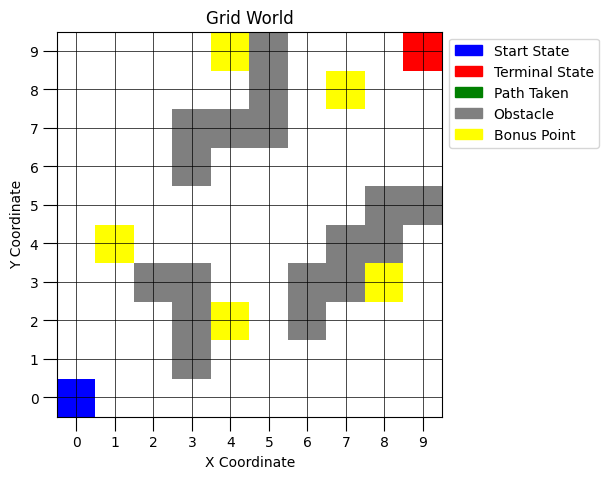

Epoch: 1/1000, Reward: -8989.0, Loss: 0.5496910214424133, Actions: 1845, Epsilon: 0.995


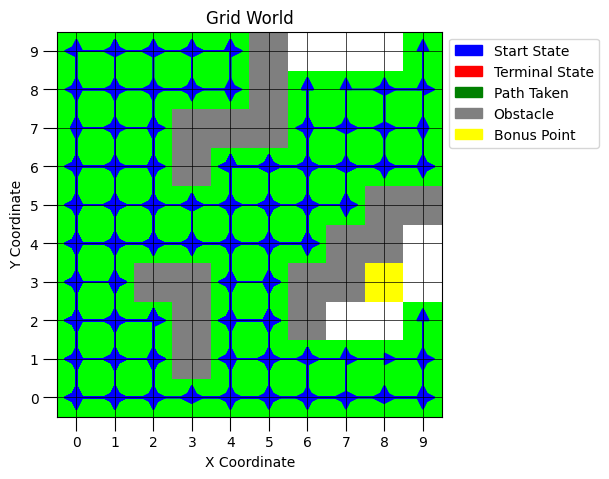

Epoch: 2/1000, Reward: -2439.0, Loss: 4.344385623931885, Actions: 538, Epsilon: 0.990025
Epoch: 3/1000, Reward: -11889.0, Loss: 0.7739976644515991, Actions: 2428, Epsilon: 0.985074875
Epoch: 4/1000, Reward: -3169.0, Loss: 1.8611212968826294, Actions: 674, Epsilon: 0.9801495006250001
Epoch: 5/1000, Reward: -5279.0, Loss: 0.7056832313537598, Actions: 1099, Epsilon: 0.9752487531218751
Epoch: 6/1000, Reward: -305.0, Loss: 0.9208004474639893, Actions: 97, Epsilon: 0.9703725093562657
Epoch: 7/1000, Reward: -979.0, Loss: 22.768640518188477, Actions: 240, Epsilon: 0.9655206468094844
Epoch: 8/1000, Reward: -12324.0, Loss: 1.23101007938385, Actions: 2515, Epsilon: 0.960693043575437
Epoch: 9/1000, Reward: -2429.0, Loss: 1.2505886554718018, Actions: 533, Epsilon: 0.9558895783575597
Epoch: 10/1000, Reward: -1074.0, Loss: 1.4310095310211182, Actions: 244, Epsilon: 0.9511101304657719
Epoch: 11/1000, Reward: -4864.0, Loss: 1.7977882623672485, Actions: 1020, Epsilon: 0.946354579813443
Epoch: 12/1000, R

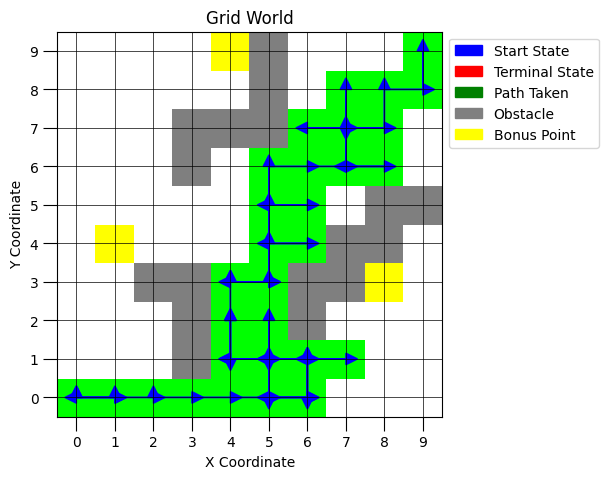

Epoch: 52/1000, Reward: -374.0, Loss: 15.827044486999512, Actions: 119, Epsilon: 0.7705488893118823
Epoch: 53/1000, Reward: -190.0, Loss: 3.562718152999878, Actions: 74, Epsilon: 0.7666961448653229
Epoch: 54/1000, Reward: -205.0, Loss: 10.324861526489258, Actions: 84, Epsilon: 0.7628626641409962
Epoch: 55/1000, Reward: -160.0, Loss: 2.962815523147583, Actions: 75, Epsilon: 0.7590483508202912
Epoch: 56/1000, Reward: -185.0, Loss: 2.6531131267547607, Actions: 65, Epsilon: 0.7552531090661897
Epoch: 57/1000, Reward: -210.0, Loss: 2.2639451026916504, Actions: 85, Epsilon: 0.7514768435208588
Epoch: 58/1000, Reward: -299.0, Loss: 1.9820337295532227, Actions: 104, Epsilon: 0.7477194593032545
Epoch: 59/1000, Reward: -755.0, Loss: 1.426018476486206, Actions: 194, Epsilon: 0.7439808620067382
Epoch: 60/1000, Reward: -1455.0, Loss: 1.240082025527954, Actions: 330, Epsilon: 0.7402609576967045
Epoch: 61/1000, Reward: -205.0, Loss: 6.7159810066223145, Actions: 84, Epsilon: 0.736559652908221
Epoch: 62/

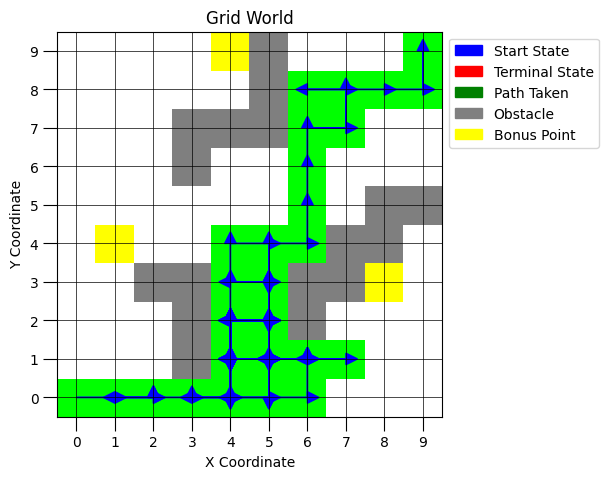

Epoch: 102/1000, Reward: -65.0, Loss: 6.943455219268799, Actions: 56, Epsilon: 0.5997278763867329
Epoch: 103/1000, Reward: -50.0, Loss: 2.9560933113098145, Actions: 38, Epsilon: 0.5967292370047992
Epoch: 104/1000, Reward: -5.0, Loss: 66.6895523071289, Actions: 37, Epsilon: 0.5937455908197752
Epoch: 105/1000, Reward: 0.0, Loss: 3.9072680473327637, Actions: 43, Epsilon: 0.5907768628656763
Epoch: 106/1000, Reward: -160.0, Loss: 3.1114630699157715, Actions: 75, Epsilon: 0.5878229785513479
Epoch: 107/1000, Reward: -60.0, Loss: 24.548898696899414, Actions: 55, Epsilon: 0.5848838636585911
Epoch: 108/1000, Reward: -270.0, Loss: 19.65496253967285, Actions: 97, Epsilon: 0.5819594443402982
Epoch: 109/1000, Reward: -100.0, Loss: 3.0470104217529297, Actions: 63, Epsilon: 0.5790496471185967
Epoch: 110/1000, Reward: -45.0, Loss: 23.59842872619629, Actions: 37, Epsilon: 0.5761543988830038
Epoch: 111/1000, Reward: -55.0, Loss: 2.9353439807891846, Actions: 54, Epsilon: 0.5732736268885887
Epoch: 112/1000

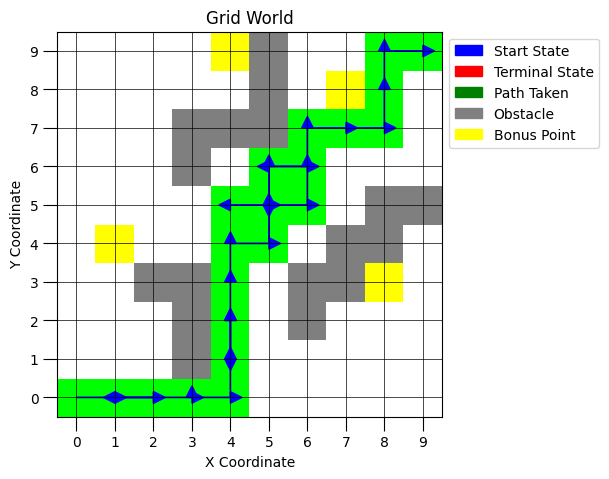

Epoch: 152/1000, Reward: 40.0, Loss: 21.993024826049805, Actions: 28, Epsilon: 0.46677573701590436
Epoch: 153/1000, Reward: 90.0, Loss: 38.272071838378906, Actions: 25, Epsilon: 0.46444185833082485
Epoch: 154/1000, Reward: 20.0, Loss: 17.462886810302734, Actions: 39, Epsilon: 0.46211964903917074
Epoch: 155/1000, Reward: -295.0, Loss: 34.268157958984375, Actions: 102, Epsilon: 0.4598090507939749
Epoch: 156/1000, Reward: 50.0, Loss: 22.930002212524414, Actions: 33, Epsilon: 0.457510005540005
Epoch: 157/1000, Reward: -25.0, Loss: 61.7767219543457, Actions: 48, Epsilon: 0.45522245551230495
Epoch: 158/1000, Reward: -170.0, Loss: 41.57715606689453, Actions: 77, Epsilon: 0.4529463432347434
Epoch: 159/1000, Reward: 15.0, Loss: 55.68653106689453, Actions: 33, Epsilon: 0.4506816115185697
Epoch: 160/1000, Reward: 5.0, Loss: 7.890838623046875, Actions: 42, Epsilon: 0.4484282034609769
Epoch: 161/1000, Reward: -5.0, Loss: 19.367839813232422, Actions: 29, Epsilon: 0.446186062443672
Epoch: 162/1000, R

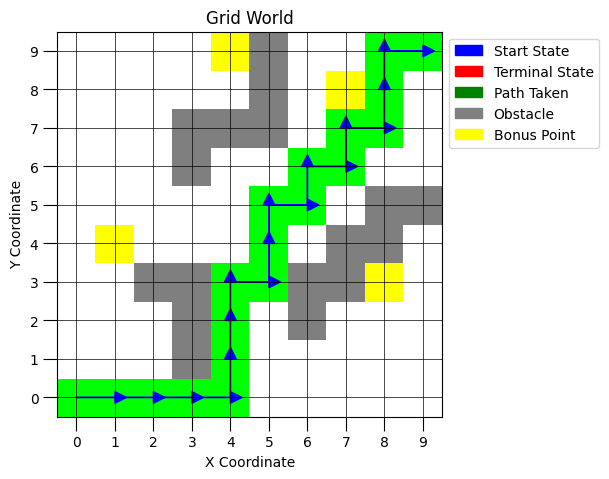

Epoch: 202/1000, Reward: 55.0, Loss: 27.72452163696289, Actions: 32, Epsilon: 0.3632974174544486
Epoch: 203/1000, Reward: 35.0, Loss: 21.16023826599121, Actions: 36, Epsilon: 0.3614809303671764
Epoch: 204/1000, Reward: 20.0, Loss: 21.817466735839844, Actions: 39, Epsilon: 0.3596735257153405
Epoch: 205/1000, Reward: 75.0, Loss: 9.82535457611084, Actions: 28, Epsilon: 0.3578751580867638
Epoch: 206/1000, Reward: 20.0, Loss: 25.70395278930664, Actions: 39, Epsilon: 0.35608578229633
Epoch: 207/1000, Reward: 80.0, Loss: 39.01222229003906, Actions: 27, Epsilon: 0.3543053533848483
Epoch: 208/1000, Reward: -5.0, Loss: 25.14261245727539, Actions: 44, Epsilon: 0.35253382661792404
Epoch: 209/1000, Reward: 35.0, Loss: 16.75920867919922, Actions: 36, Epsilon: 0.3507711574848344
Epoch: 210/1000, Reward: 105.0, Loss: 6.850985050201416, Actions: 22, Epsilon: 0.34901730169741024
Epoch: 211/1000, Reward: 10.0, Loss: 43.50265121459961, Actions: 41, Epsilon: 0.3472722151889232
Epoch: 212/1000, Reward: -75.

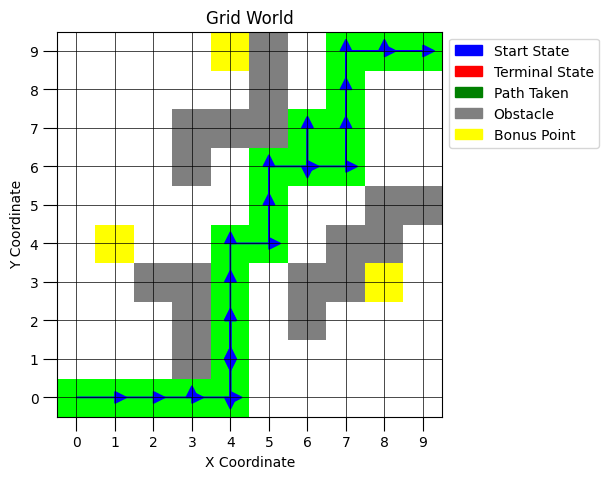

Epoch: 252/1000, Reward: 60.0, Loss: 29.13858413696289, Actions: 31, Epsilon: 0.2827589419554058
Epoch: 253/1000, Reward: 70.0, Loss: 35.790157318115234, Actions: 29, Epsilon: 0.28134514724562876
Epoch: 254/1000, Reward: 85.0, Loss: 35.974117279052734, Actions: 26, Epsilon: 0.2799384215094006
Epoch: 255/1000, Reward: 45.0, Loss: 23.90658187866211, Actions: 34, Epsilon: 0.27853872940185365
Epoch: 256/1000, Reward: 50.0, Loss: 37.854156494140625, Actions: 26, Epsilon: 0.27714603575484437
Epoch: 257/1000, Reward: 70.0, Loss: 23.95541763305664, Actions: 29, Epsilon: 0.2757603055760701
Epoch: 258/1000, Reward: 80.0, Loss: 28.968551635742188, Actions: 27, Epsilon: 0.2743815040481898
Epoch: 259/1000, Reward: -275.0, Loss: 23.795581817626953, Actions: 98, Epsilon: 0.2730095965279488
Epoch: 260/1000, Reward: 30.0, Loss: 50.280235290527344, Actions: 37, Epsilon: 0.27164454854530906
Epoch: 261/1000, Reward: -10.0, Loss: 43.027801513671875, Actions: 45, Epsilon: 0.2702863258025825
Epoch: 262/1000,

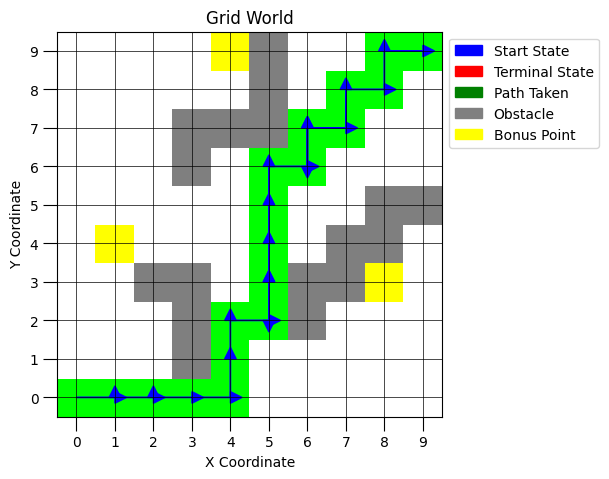

Epoch: 302/1000, Reward: 105.0, Loss: 6.923087120056152, Actions: 22, Epsilon: 0.22007483514733558
Epoch: 303/1000, Reward: 115.0, Loss: 26.38003158569336, Actions: 20, Epsilon: 0.2189744609715989
Epoch: 304/1000, Reward: 70.0, Loss: 44.438758850097656, Actions: 29, Epsilon: 0.2178795886667409
Epoch: 305/1000, Reward: 75.0, Loss: 39.32974624633789, Actions: 28, Epsilon: 0.2167901907234072
Epoch: 306/1000, Reward: 80.0, Loss: 20.564403533935547, Actions: 27, Epsilon: 0.21570623976979014
Epoch: 307/1000, Reward: 95.0, Loss: 23.91207504272461, Actions: 24, Epsilon: 0.21462770857094118
Epoch: 308/1000, Reward: 85.0, Loss: 28.92732810974121, Actions: 26, Epsilon: 0.21355457002808648
Epoch: 309/1000, Reward: 110.0, Loss: 25.948760986328125, Actions: 21, Epsilon: 0.21248679717794605
Epoch: 310/1000, Reward: 115.0, Loss: 22.94110870361328, Actions: 20, Epsilon: 0.21142436319205632
Epoch: 311/1000, Reward: 110.0, Loss: 74.3433837890625, Actions: 21, Epsilon: 0.21036724137609603
Epoch: 312/1000,

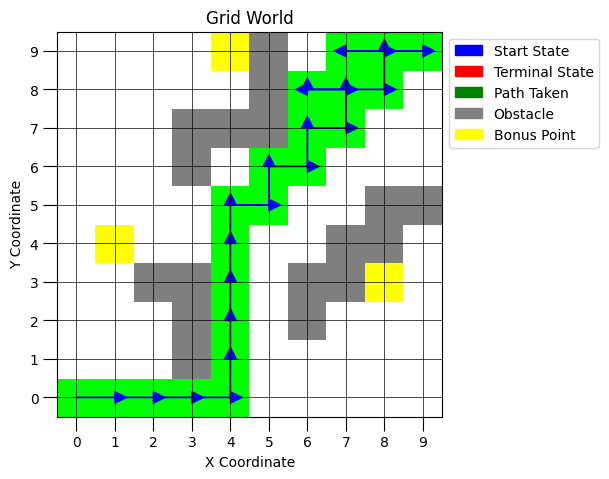

Epoch: 352/1000, Reward: 95.0, Loss: 39.782508850097656, Actions: 24, Epsilon: 0.1712870076899825
Epoch: 353/1000, Reward: 65.0, Loss: 41.68901062011719, Actions: 30, Epsilon: 0.17043057265153258
Epoch: 354/1000, Reward: 110.0, Loss: 20.936532974243164, Actions: 21, Epsilon: 0.16957841978827493
Epoch: 355/1000, Reward: 115.0, Loss: 6.380138397216797, Actions: 20, Epsilon: 0.16873052768933355
Epoch: 356/1000, Reward: 115.0, Loss: 44.21192932128906, Actions: 20, Epsilon: 0.1678868750508869
Epoch: 357/1000, Reward: 105.0, Loss: 7.365594863891602, Actions: 22, Epsilon: 0.16704744067563246
Epoch: 358/1000, Reward: 105.0, Loss: 22.297147750854492, Actions: 22, Epsilon: 0.1662122034722543
Epoch: 359/1000, Reward: 115.0, Loss: 22.614843368530273, Actions: 20, Epsilon: 0.16538114245489302
Epoch: 360/1000, Reward: 110.0, Loss: 22.90616798400879, Actions: 21, Epsilon: 0.16455423674261854
Epoch: 361/1000, Reward: 105.0, Loss: 23.19474983215332, Actions: 22, Epsilon: 0.16373146555890544
Epoch: 362/

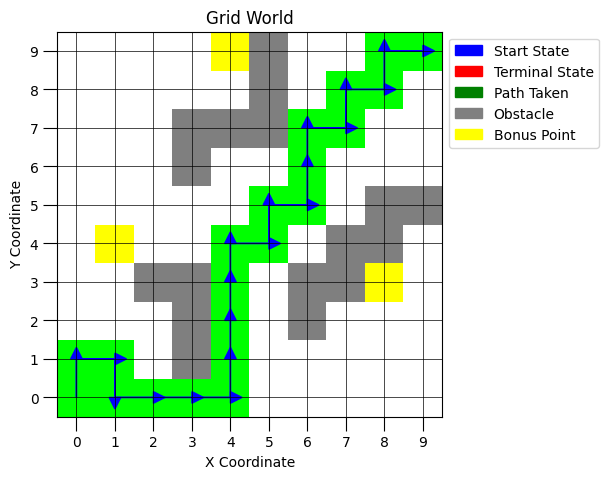

Epoch: 402/1000, Reward: 125.0, Loss: 45.40971755981445, Actions: 18, Epsilon: 0.13331482894782642
Epoch: 403/1000, Reward: 115.0, Loss: 9.96963882446289, Actions: 20, Epsilon: 0.13264825480308728
Epoch: 404/1000, Reward: 115.0, Loss: 24.85580825805664, Actions: 20, Epsilon: 0.13198501352907185
Epoch: 405/1000, Reward: 115.0, Loss: 21.860504150390625, Actions: 20, Epsilon: 0.1313250884614265
Epoch: 406/1000, Reward: 105.0, Loss: 24.545059204101562, Actions: 22, Epsilon: 0.13066846301911936
Epoch: 407/1000, Reward: 125.0, Loss: 22.813365936279297, Actions: 18, Epsilon: 0.13001512070402377
Epoch: 408/1000, Reward: 60.0, Loss: 7.015190601348877, Actions: 24, Epsilon: 0.12936504510050365
Epoch: 409/1000, Reward: 95.0, Loss: 4.739448547363281, Actions: 24, Epsilon: 0.12871821987500112
Epoch: 410/1000, Reward: 125.0, Loss: 10.057869911193848, Actions: 18, Epsilon: 0.12807462877562611
Epoch: 411/1000, Reward: 125.0, Loss: 5.697607040405273, Actions: 18, Epsilon: 0.12743425563174798
Epoch: 412

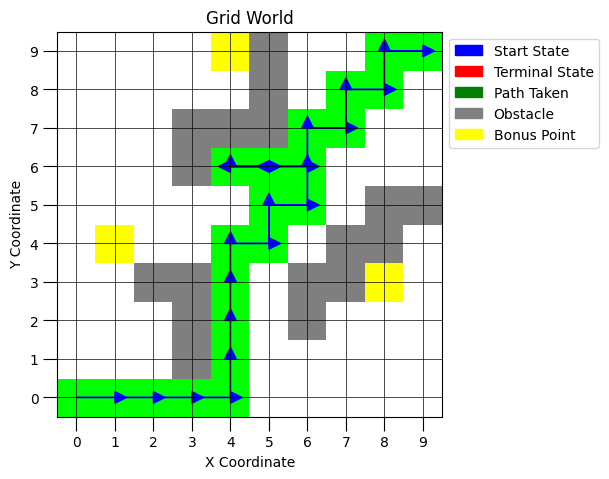

Epoch: 452/1000, Reward: 100.0, Loss: 6.701653480529785, Actions: 23, Epsilon: 0.10376060541355137
Epoch: 453/1000, Reward: 95.0, Loss: 5.480713367462158, Actions: 24, Epsilon: 0.1032418023864836
Epoch: 454/1000, Reward: 110.0, Loss: 22.41200065612793, Actions: 21, Epsilon: 0.10272559337455119
Epoch: 455/1000, Reward: 65.0, Loss: 66.66006469726562, Actions: 30, Epsilon: 0.10221196540767843
Epoch: 456/1000, Reward: 25.0, Loss: 3.926222801208496, Actions: 38, Epsilon: 0.10170090558064004
Epoch: 457/1000, Reward: 95.0, Loss: 23.70344352722168, Actions: 24, Epsilon: 0.10119240105273684
Epoch: 458/1000, Reward: 36.0, Loss: 2.2272942066192627, Actions: 22, Epsilon: 0.10068643904747315
Epoch: 459/1000, Reward: 56.0, Loss: 24.348997116088867, Actions: 18, Epsilon: 0.10018300685223579
Epoch: 460/1000, Reward: 41.0, Loss: 12.748383522033691, Actions: 21, Epsilon: 0.0996820918179746
Epoch: 461/1000, Reward: 41.0, Loss: 23.373945236206055, Actions: 21, Epsilon: 0.09918368135888474
Epoch: 462/1000,

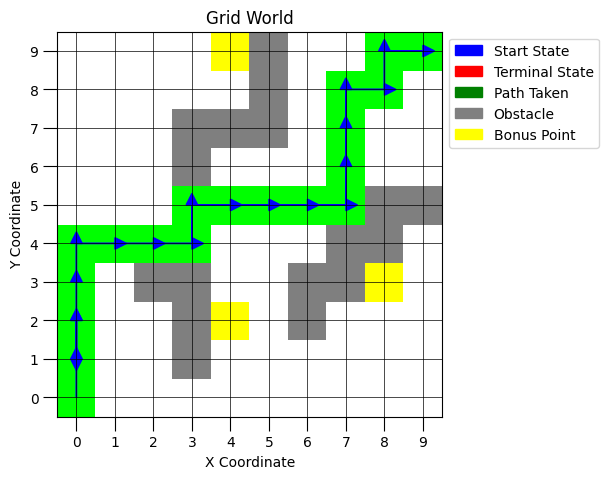

Epoch: 502/1000, Reward: 31.0, Loss: 10.645198822021484, Actions: 23, Epsilon: 0.08075818212241151
Epoch: 503/1000, Reward: 46.0, Loss: 4.986881732940674, Actions: 20, Epsilon: 0.08035439121179945
Epoch: 504/1000, Reward: 56.0, Loss: 20.92592430114746, Actions: 18, Epsilon: 0.07995261925574046
Epoch: 505/1000, Reward: 56.0, Loss: 9.502792358398438, Actions: 18, Epsilon: 0.07955285615946175
Epoch: 506/1000, Reward: 56.0, Loss: 4.017285346984863, Actions: 18, Epsilon: 0.07915509187866444
Epoch: 507/1000, Reward: 56.0, Loss: 5.350971221923828, Actions: 18, Epsilon: 0.07875931641927113
Epoch: 508/1000, Reward: 46.0, Loss: 5.08099365234375, Actions: 20, Epsilon: 0.07836551983717477
Epoch: 509/1000, Reward: 56.0, Loss: 22.168622970581055, Actions: 18, Epsilon: 0.07797369223798889
Epoch: 510/1000, Reward: 115.0, Loss: 19.728078842163086, Actions: 20, Epsilon: 0.07758382377679894
Epoch: 511/1000, Reward: 105.0, Loss: 21.072782516479492, Actions: 22, Epsilon: 0.07719590465791494
Epoch: 512/1000

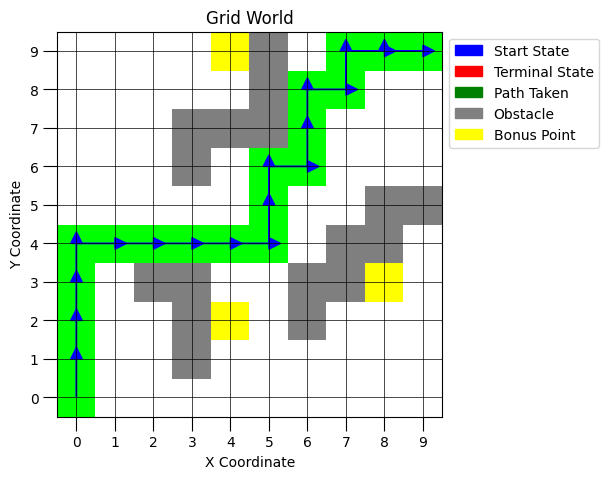

Epoch: 552/1000, Reward: 46.0, Loss: 6.743875503540039, Actions: 20, Epsilon: 0.06285510723190912
Epoch: 553/1000, Reward: 56.0, Loss: 2.319258213043213, Actions: 18, Epsilon: 0.06254083169574957
Epoch: 554/1000, Reward: 56.0, Loss: 4.812031269073486, Actions: 18, Epsilon: 0.062228127537270826
Epoch: 555/1000, Reward: 56.0, Loss: 23.802265167236328, Actions: 18, Epsilon: 0.06191698689958447
Epoch: 556/1000, Reward: 56.0, Loss: 1.379618525505066, Actions: 18, Epsilon: 0.061607401965086545
Epoch: 557/1000, Reward: 46.0, Loss: 8.255655288696289, Actions: 20, Epsilon: 0.06129936495526111
Epoch: 558/1000, Reward: 51.0, Loss: 2.866142749786377, Actions: 19, Epsilon: 0.0609928681304848
Epoch: 559/1000, Reward: 56.0, Loss: 4.300742149353027, Actions: 18, Epsilon: 0.060687903789832374
Epoch: 560/1000, Reward: 56.0, Loss: 4.300686359405518, Actions: 18, Epsilon: 0.06038446427088321
Epoch: 561/1000, Reward: 46.0, Loss: 9.097193717956543, Actions: 20, Epsilon: 0.06008254194952879
Epoch: 562/1000, 

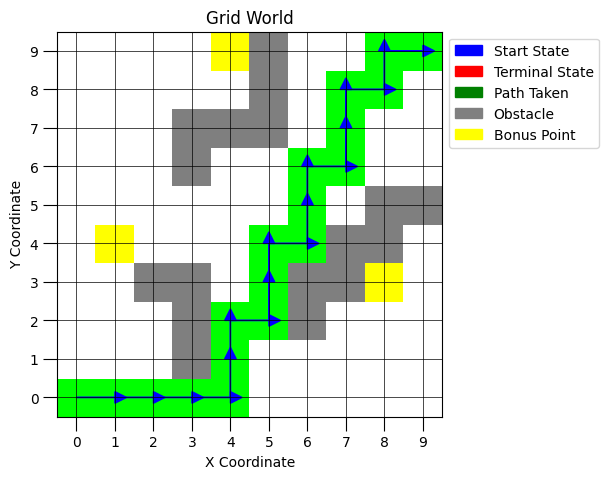

Epoch: 602/1000, Reward: 90.0, Loss: 3.3017663955688477, Actions: 25, Epsilon: 0.04892091923449087
Epoch: 603/1000, Reward: 105.0, Loss: 12.195068359375, Actions: 22, Epsilon: 0.04867631463831842
Epoch: 604/1000, Reward: 115.0, Loss: 19.08488655090332, Actions: 20, Epsilon: 0.048432933065126825
Epoch: 605/1000, Reward: 115.0, Loss: 13.728055953979492, Actions: 20, Epsilon: 0.048190768399801194
Epoch: 606/1000, Reward: 115.0, Loss: 20.476097106933594, Actions: 20, Epsilon: 0.04794981455780219
Epoch: 607/1000, Reward: 125.0, Loss: 9.221656799316406, Actions: 18, Epsilon: 0.04771006548501318
Epoch: 608/1000, Reward: 115.0, Loss: 11.953990936279297, Actions: 20, Epsilon: 0.047471515157588115
Epoch: 609/1000, Reward: 75.0, Loss: 13.371030807495117, Actions: 28, Epsilon: 0.047234157581800176
Epoch: 610/1000, Reward: 35.0, Loss: 7.97300910949707, Actions: 36, Epsilon: 0.046997986793891174
Epoch: 611/1000, Reward: 15.0, Loss: 6.4860687255859375, Actions: 40, Epsilon: 0.04676299685992172
Epoch:

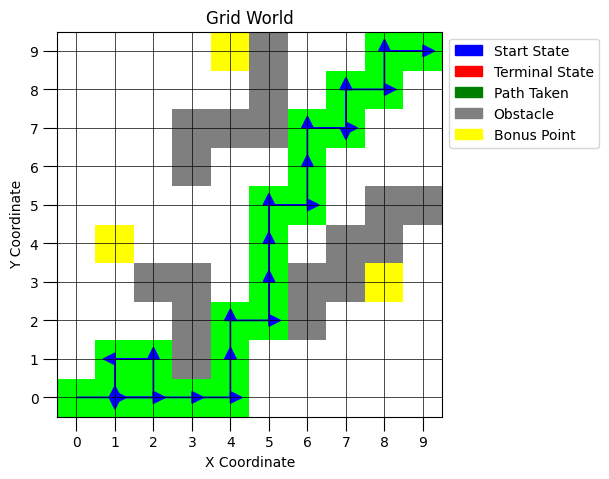

Epoch: 652/1000, Reward: 110.0, Loss: 9.590825080871582, Actions: 21, Epsilon: 0.038075765743545126
Epoch: 653/1000, Reward: 125.0, Loss: 26.556625366210938, Actions: 18, Epsilon: 0.0378853869148274
Epoch: 654/1000, Reward: 115.0, Loss: 21.655899047851562, Actions: 20, Epsilon: 0.03769595998025326
Epoch: 655/1000, Reward: 125.0, Loss: 5.695474624633789, Actions: 18, Epsilon: 0.03750748018035199
Epoch: 656/1000, Reward: 125.0, Loss: 7.613795280456543, Actions: 18, Epsilon: 0.037319942779450235
Epoch: 657/1000, Reward: 115.0, Loss: 6.257047653198242, Actions: 20, Epsilon: 0.037133343065552986
Epoch: 658/1000, Reward: 125.0, Loss: 22.834165573120117, Actions: 18, Epsilon: 0.03694767635022522
Epoch: 659/1000, Reward: 120.0, Loss: 21.09731101989746, Actions: 19, Epsilon: 0.036762937968474095
Epoch: 660/1000, Reward: 125.0, Loss: 2.8736305236816406, Actions: 18, Epsilon: 0.03657912327863173
Epoch: 661/1000, Reward: 125.0, Loss: 9.534170150756836, Actions: 18, Epsilon: 0.036396227662238566
Ep

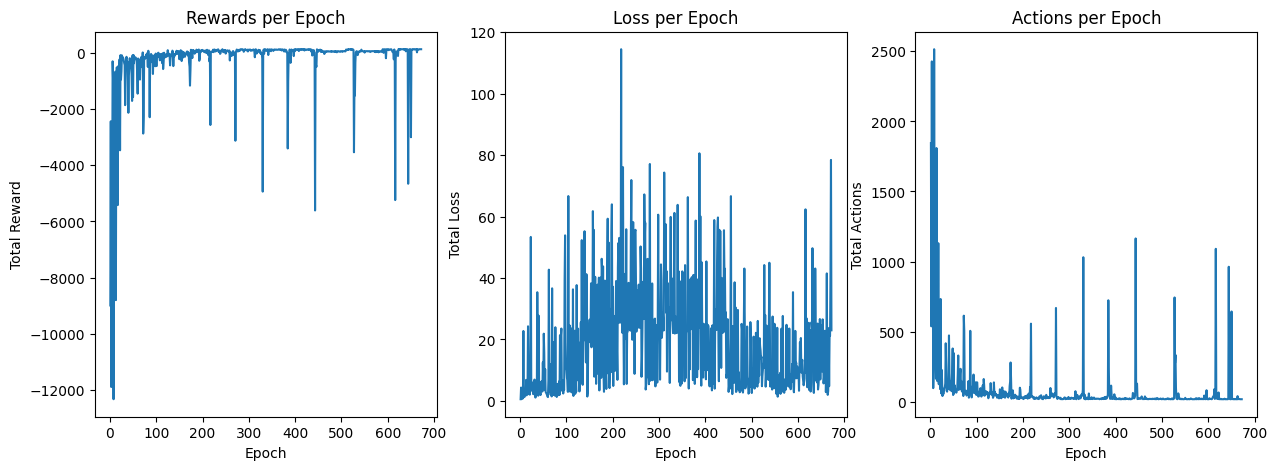

In [96]:
file_name = train_DDQNagent()
plot_results_from_csv(file_name)